<a href="https://colab.research.google.com/github/johsieders/fttai/blob/main/src/cola/colaB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# from https://mccormickml.com/2019/07/22/BERT-fine-tuning
# The Corpus of Linguistic Acceptability (CoLA)

# Johannes Siedersleben
# QAware GmbH, Munich
# 10.2.2021

In [ ]:
# uncomment this if import fails
# !pip install wget

import os
import zipfile
import wget

In [ ]:
# download and unzip raw data

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

zipped_file = 'cola_public_1.1.zip'
zipped_dir = './cola_public_1.1/'
unzipped_file = './cola_public/raw/in_domain_train.tsv'

if not os.path.exists(zipped_file):
    wget.download(url, zipped_file)
print('download successful')

if not os.path.exists(zipped_dir):
    zip = zipfile.ZipFile(zipped_file)
    zip.extractall()

print('unzipped file now at ' + unzipped_file)

In [ ]:
from torch import Tensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# utilities for display
import seaborn as sns
import matplotlib.pyplot as plt


def plot(history):
    plt.plot(history, label='training loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('loss')
    plt.xlabel('iterations')


def showMetrics(labels, predictions: Tensor) -> None:
    """"
    @param labels: tensor of labels
    @param predictions: tensor of prediction
    @return: None
    This functions prints accuracy, precision, recall and f1
    """
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f'\naccuracy  = {accuracy:.3f}\n'
          f'precision = {precision:.3f}\n'
          f'recall    = {recall:.3f}\n'
          f'f1        = {f1:.3f}')


def showConfusionMatrix(labels, predictions: Tensor, names: list) -> None:
    """
    @param labels: tensor of labels
    @param predictions: tensor of prediction
    @param names: names of categories, e.g. ['correct', 'incorrect']
    @return: None
    The confusion matrix is a K x K matrix with K = number of categories
    """

    cm = confusion_matrix(labels, predictions)
    vmax = cm.max()   # number of categories
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=names, yticklabels=names, vmin=0, vmax=vmax, cmap="YlGnBu")
    plt.xlabel = ('true label')
    plt.ylabel = ('predicted label')
    plt.show()

In [ ]:
# uncomment this if import fails
# !pip install transformers

# Python imports
import random
import pickle
from collections.abc import Callable
from time import perf_counter

# utilities for download and file import
import pandas as pd

# neural metworks support: torch, Huggingface transformers
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW


In [ ]:
class Logger(object):
    def __init__(self):
        self.protocol = []
        self.counter = 0
        self.char_counter = 0

    def log(self, input: any) -> None:
        print(self.counter, end='')  # I am working
        self.counter = (self.counter + 1) % 10
        self.char_counter =(self.char_counter + 1) % 80
        if self.char_counter == 0:
          print()
        self.protocol.append((perf_counter(), input))

    def getProtocol(self) -> list:
        return self.protocol

In [ ]:
class Learner(object):
    def __init__(self, module: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 loss_fct: Callable,
                 device: torch.device):
        self.module = module
        self.optimizer = optimizer
        self.loss_fct = loss_fct
        self.device = device

    def train(self, dataloader: DataLoader, logger: Logger) -> None:
        """
        @param dataloader: a dataloader with input_ids at 0, labels at 1
        @param logger: a logger
        @return: None
        This is one epoch, the essential loop of artificial intelligence.
        It runs over all training sentences, one minibatch at a time.
        One loop takes about 2 seconds on a i7 cpu!
        """
        self.module.train()

        for batch in dataloader:
            vectors, labels = batch
            labels = labels.view(-1, 1)
            logits = self.module(vectors)
            loss = self.loss_fct(logits, labels)
            logger.log(loss.item())
            loss.backward()  # compute gradient
            clip_grad_norm_(module.parameters(), 1.0)  # normalize gradient
            self.optimizer.step()  # do one optimization step
            self.optimizer.zero_grad()  # reset gradient

    def predict(self, dataloader: DataLoader) -> tuple:
        """
        @param dataloader: a dataloader with input_ids at 0, labels at 2
        @return: tuple of (label, prediction), two tensors
        """
        self.module.eval()
        targets = torch.tensor((), dtype=torch.int, device=self.device)
        predictions = torch.tensor((), dtype=torch.int, device=self.device)

        for batch in dataloader:
            vectors, labels = batch
            with torch.no_grad():
                logits = self.module(vectors)
            preds = torch.argmax(logits, dim=1)
            targets = torch.cat((targets, labels))    # collect targets
            predictions = torch.cat((predictions, preds))  # collect predictions

        return targets, predictions

    def fit(self, dataloader: DataLoader, n_epochs: int) -> list:
        """
        @param dataloader: a dataloader with input_ids at 0, attention_mask at 1, labels at 2
        @param n_epochs: number of epochs
        @return: the protocol
        """
        logger = Logger()
        for i in range(n_epochs):
            logger.log(f'epoch {i}')
            self.train(dataloader, logger)
        return logger.getProtocol()

In [ ]:
def getDevice(cuda_desired: bool) -> torch.device:
    """
    @param cuda_desired: True if cuda desired
    @return: cuda if desired and available, cpu otherwise
    """
    return torch.device('cuda') if cuda_desired and torch.cuda.is_available() \
        else torch.device('cpu')

In [ ]:
def readSentencesLabels(filename: str,
                        n_sentences: int,
                        col_sentence: int,
                        col_label: int,
                        delimiter: str = '\t') -> tuple:
    """
    @param filename: file to be read from
    @param n_sentences: number of sentences to be read
    @param delimiter: a delimiter
    @param col_sentence: index of column of sentences
    @param col_label: index of column of labels
    @return: a tuple containing a list of sentences and a list of labels
    """
    df = pd.read_csv(filename, delimiter=delimiter, nrows=n_sentences, header=None)
    return df[col_sentence].values.tolist(), df[col_label].values.tolist()

In [ ]:
def tokenize(sentences: list,
             tokenizer: BertTokenizer,
             model: BertModel,
             device: torch.device,
             max_length: int) -> Tensor:
    """
    @param sentences: list of sentences
    @param tokenizer: a tokenizer
    @param max_length: sentences to be padded to
    @return: list of vectors
    Encoding proceeds as follows:
    (1) Tokenize the sentence.
    (2) Prepend the `[CLS]` token to the start.
    (3) Append the `[SEP]` token to the end.
    (4) Map tokens to their IDs.
    (5) Pad or truncate the sentence to `max_length`
    (6) Create attention mask for [PAD] tokens.

    Note: pad_to_max_length is deprecated, no way to get around.
    """
    vectors = []

    for s in sentences:
        dict = tokenizer(s,
                         add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                         truncation=True,
                         max_length=max_length,
                         pad_to_max_length=True,
                         return_attention_mask=True,
                        )
        # token_ids.append(encoded_dict['input_ids'])
        # attention_masks.append(encoded_dict['attention_mask'])
        # third entry (token_type_ids) not needed

        toks = dict['input_ids']
        attn = dict['attention_mask']
        token_ids = torch.tensor(toks, device=device).view((1, -1))
        attn_mask = torch.tensor(attn, device=device).view((1, -1))

        with torch.no_grad():
            output = model(token_ids, attn_mask)

        hidden_states = output[2]
        token_vectors = hidden_states[-2][0]  # shape = (#tokens, 768)
        # result[i] = average token_vecs[i, j], j = 0 .. 767
        vector = torch.mean(token_vectors, dim=0)  # shape = (768)
        vectors.append(vector)

    vectors = torch.cat(vectors).view(len(sentences), -1)
    return vectors

In [ ]:
def getDataloader(token_ids: Tensor,
                  labels: Tensor,
                  split_factor: float,
                  batch_size: int,
                  device: torch.device) -> tuple:
    """
    @param token_ids: token_ids, plain Python list, (n_sentences x max_length)
    @param labels: labels, plain Python list (len = n_sentences)
    @param split_factor: share of training sentences
    @param batch_size: size of minibatch
    @param device: device the dataloaders are on
    @return: tuple of two dataloaders, one for training and one for test

    Dataloaders return on each call a list of k 3-tupels (token_ids, attention_mask, label);
    with k = batch_size. All returned elements are torch.tensors on the requested device
    """

    dataset = TensorDataset(token_ids, labels)
    train_size = int(split_factor * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )

    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    return train_dataloader, test_dataloader

In [ ]:
def getModule_for_tokenizing(device: torch.device) -> BertModel:
    module = BertModel.from_pretrained(
        "bert-base-uncased",  # Use the 12-layer BERT module, with an uncased vocab.
        output_hidden_states=True,  # return hidden-states.
    )
    module.eval()

    if device == torch.device('cpu'):
        module.cpu()
    else:
        module.cuda()
    return module

In [ ]:
def getModule(device: torch.device) -> nn.Module:
    module = nn.Linear(768, 1)
    if device == torch.device('cpu'):
        module.cpu()
    else:
        module.cuda()
    return module

In [ ]:
def getTokenizer() -> BertTokenizer:
    """
    @return: the Bert Tokenizer
    """
    return BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def getOptimizer(module: nn.Module,
                 lr: float,
                 eps: float) -> torch.optim.Optimizer:
    """
    @param module: a module
    @param lr: learning rate
    @param eps: stop criterion
    @return: the Adam optimizer (any other choice is valid)
    """
    return AdamW(module.parameters(), lr=lr, eps=eps)


In [ ]:
# put constants in a dictionary
cfg = {'seed': 2,
   'batch_size': 16,
   'n_sentences': 200,  # number of sentences to read
   'max_length': 64,      # max length of sentence (guess or find out)
   'split_factor': 0.8,   # share of training sentences
   'cuda_desired': False,  # True if cuda desired
   'lr': 3e-5,            # learning rate of optimizer
   'eps': 1e-8,           # stop criterion of optimizer
   'n_epochs' : None}     # number of epochs

seed = cfg['seed']
batch_size = cfg['batch_size']
n_sentences = cfg['n_sentences']
max_length = cfg['max_length']
split_factor = cfg['split_factor']
cuda_desired = cfg['cuda_desired']
lr = cfg['lr']
eps = cfg['eps']

# seed randomizers
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# extract at most n sentences and labels; n = n_sentences
unzipped_file = './cola_public/raw/in_domain_train.tsv'
col_sentence = 3  # index of column of sentences
col_label = 1  # index of column of labels

sentences, labels = readSentencesLabels(unzipped_file, n_sentences, col_sentence, col_label)

n = len(sentences)
k = len(list(filter(lambda x: x == 1, labels)))

print(n, k)

In [ ]:
# define the algorithm
device = getDevice(cuda_desired)  # device depending on choice and availability of cuda
module_for_tokenizing = getModule_for_tokenizing(device)  # BertModel.from_pretrained
module = getModule(device)     # Linear(768, 1)
tokenizer = getTokenizer()     # BERTtokenizer.from_pretrained; that's WordPiece
optimizer = getOptimizer(module, lr, eps)

# tokenize sentences to token ids and attention masks
token_ids = tokenize(sentences, tokenizer, module_for_tokenizing, device, max_length)
labels = torch.tensor(labels, dtype=torch.float32, device=device)

# put token ids, attention masks and labels into a dataloader
train_dataloader, test_dataloader = \
            getDataloader(token_ids, labels, split_factor, batch_size, device)

In [ ]:
# build a learner and get going
cfg['n_epochs'] = 4
learner = Learner(module, optimizer, nn.BCEWithLogitsLoss(), device)
protocol = learner.fit(train_dataloader, cfg['n_epochs'])
print('\nfitting finished')

# make predictions on train and test data
train_labels, train_predictions = learner.predict(train_dataloader)
test_labels, test_predictions = learner.predict(test_dataloader)
log_object = (cfg,
              protocol,
              train_labels, train_predictions,
              test_labels, test_predictions)

# save protocol
log_file = 'log_000.pickle'
with open(log_file, 'wb') as log:
    pickle.dump(log_object, log)


elapsed time = 0.0974

total number of train labels:         160
total number of correct train labels: 106


TypeError: 'str' object is not callable

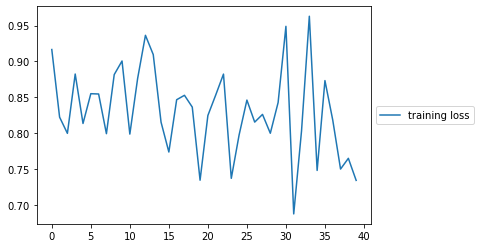

In [25]:
# How did we do?

log_file = 'log_000.pickle'
with open(log_file, 'rb') as log:
    log_object = pickle.load(log)

cfg, protocol, \
train_labels, train_predictions, \
test_labels, test_predictions = log_object

elapsed_time = protocol[-1][0] - protocol[0][0]
print(f'\nelapsed time = {elapsed_time:.4f}')

# show the outcome
print(f"\ntotal number of train labels:         {len(train_labels)}\n"
  f"total number of correct train labels: {len(list(filter(lambda x: x == 1, train_labels)))}")

losses = [protocol[i][1] for i in range(len(protocol))
          if type(protocol[i][1]) is float]
plot(losses)

In [ ]:
cat_names = ['incorrect', 'correct']
print('\nresult on test data')
showConfusionMatrix(train_labels, train_predictions, cat_names)
print('\nresult on test data')
showConfusionMatrix(test_labels, test_predictions, cat_names)

print('\nresult on train data')
showMetrics(train_labels, train_predictions)
print('\nresult on test data')
showMetrics(test_labels, test_predictions)